# <center>Телеком: исследование оттока клиентов</center>
___
___

# <center>Описание задачи</center>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Информация о договорах актуальна на 1 февраля 2020.

Целевой признак: столбец `'EndDate'` равен `'No'`.

Основная метрика: AUC-ROC.

Дополнительная метрика: Accuracy.

Критерии оценки:

- AUC-ROC < 0.75 — 0 sp
- 0.75 ≤ AUC-ROC < 0.81 — 4 sp
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
- 0.85 ≤ AUC-ROC < 0.87 — 5 sp
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
- AUC-ROC ≥ 0.88 — 6 sp

___
___

# <center>Описание данных</center>

Данные представлены в четырёх csv-файлах:   

1. `contract` - информация о договоре:   



2. `internet` - информация об интернет-услугах:   



3. `personal` - персональные данные клиента:   



4. `phone` - информация об услугах телефонии:   


Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.
___
___

<a id = 'back'></a>
# <center>Содержание</center>

[1. Подготовка данных.](#Chapter_1)   
   
[2. Работа с моделями.](#Chapter_2)   
   - [2.1. CatBoost](#2.1)
   - [2.2. RandomForestClassifier](#2.2)   

[3. Выводы](#Conclusions)
___
___

# <center>Ход работы</center>

### Импортируем необходимые библиотеки

In [1]:
#!pip install pandas_profiling

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import datetime

<a id = 'Chapter_1'></a>
# 1. Подготовка данных.
___

Исследовательский анализ данных был выполнен в предыдущей работе. По его результатам особой предобработки данных не требуется, так что далее просто приведем данные к виду, который можно скормить ML-моделям. Перед нами стоит задача классификации, поехали.

Загрузка данных.

contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')
print(contract)

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')
ACTUAL_DATE = datetime.date(2020, 2, 1)

Перед объединением таблиц добавим в датафреймы `internet` и `phone` колонки, служащие индикатором того, является ли клиент пользователем интернета или телефона. После добавления объединим в один датафрейм и изучим его средствами 'pandas_profiling'.

In [4]:
internet['internet'] = 'Yes'
phone['phone'] = 'Yes'
full_data = personal.merge(contract, on = 'customerID', how = 'outer').merge(internet, on = 'customerID', how = 'outer').merge(phone, on = 'customerID', how = 'outer')
full_data.fillna(value = 'No', inplace = True)
full_data['TotalCharges'] = full_data['TotalCharges'].str.replace(' ','0.0')
full_data['TotalCharges'] = pd.to_numeric(full_data['TotalCharges'])
full_data['EndDate'] = full_data['EndDate'].replace('No', ACTUAL_DATE)
full_data['EndDate'] = pd.to_datetime(full_data['EndDate'], format = "%Y-%m-%d")
full_data['BeginDate'] = pd.to_datetime(full_data['BeginDate'], format = "%Y-%m-%d")
full_data['duration'] = (full_data['EndDate'] - full_data['BeginDate']).dt.days
print(full_data['duration'])
#pandas_profiling.ProfileReport(full_data)

0         31
1       1036
2         61
3       1371
4         61
        ... 
7038     730
7039    2191
7040     337
7041     123
7042    2010
Name: duration, Length: 7043, dtype: int64


`Pandas-profiling` позволяет получить достаточно информации о данных, чтобы понять основы подготовки их к принятию ML-моделью.   
В частности сначала мы:   
- избавимся от признаков `customerID` и `gender` (с  первым все понятно - столбец полностью из уникальных значений, `gender` же, во-первых, не коррелирует ни с какими другими данными, во-вторых, информация из будущего - наличие этого столбца немного ухудшает качество предсказаний рассмотренных моделей);   
- избавимся от признака `BeginDate`, оставим от него только год;   
- признаки с типом `boolean` заменим на числовой тип (CatBoost не съест этот признак, даже если указать его как категориальный);   
- из признака `EndDate` (целевой) сделаем категориальный - вместо `No` - 1, вместо даты - 0 (клиент ушёл);

In [5]:
usefull_data = full_data.drop(['customerID', 'gender', 'SeniorCitizen', 'Partner'], axis = 1)

In [6]:
#usefull_data = full_data.drop(['customerID', 'gender'], axis = 1)
#usefull_data['startYear'] = pd.DatetimeIndex(usefull_data['BeginDate']).year
usefull_data.drop(['BeginDate'], axis = 1, inplace = True)
usefull_data['isClient'] = usefull_data['EndDate'].apply(lambda x: 1 if x == ACTUAL_DATE else 0)
usefull_data.drop(['EndDate'], axis = 1, inplace = True)
#usefull_data['Partner'] = usefull_data['Partner'].apply(lambda x: 1 if x == 'Yes' else 0)
usefull_data['Dependents'] = usefull_data['Dependents'].apply(lambda x: 1 if x == 'Yes' else 0)
#usefull_data['SeniorCitizen'] = usefull_data['SeniorCitizen'].apply(lambda x: 1 if x == 'Yes' else 0)
usefull_data['PaperlessBilling'] = usefull_data['PaperlessBilling'].apply(lambda x: 1 if x == 'Yes' else 0)

In [7]:
usefull_data.head(3)

,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,duration,isClient
0,0,Month-to-month,1,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Yes,No,No,31,1
1,0,One year,0,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes,1036,1
2,0,Month-to-month,1,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes,61,0


Мы рассмотрим две модели: `CatBoost` и `RandomForestClassifier` (далее по тексту `rfc`). Следовательно подготовленные выше данные с категориальными признаками `CatBoost` съест и попросит ещё, а для `rfc` данные необходимо преобразовать, мы будем использовать `OrdinalEncoder`.

In [8]:
encoder = OrdinalEncoder()
usefull_data_enc = pd.DataFrame(encoder.fit_transform(usefull_data), columns = usefull_data.columns)

Теперь для каждого набора нам необходимо получить три выборки: учебную, валидационную и тестовую. Напишем функцию для разбиения, чтобы не копипастить код.

In [9]:
def split_data(data, train_part, target_col):
    train, interim = train_test_split(data, test_size = train_part, random_state = 481516)
    valid, test = train_test_split(interim, test_size = 0.5, random_state = 481516)
    features_train = train.drop([target_col], axis = 1)
    target_train = train[target_col]
    features_valid = valid.drop([target_col], axis = 1)
    target_valid = valid[target_col]
    features_test = test.drop([target_col], axis = 1)
    target_test = test[target_col]
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

Разобьем оба наших набора данных (обучающую выборку возьмем в размере 0,7 от исходной, которая и так небольшая).

In [10]:
features_train, target_train, features_valid, target_valid, features_test, target_test = split_data(usefull_data,
                                                                                                   0.3, 'isClient')
features_train_enc, target_train_enc, features_valid_enc, target_valid_enc, features_test_enc, target_test_enc = split_data(usefull_data_enc,
                                                                                                   0.3, 'isClient')

Мы имеем дело с несбалансированной классификацией, поэтому напишем функцию для апсемплинга и применим её к нашим данным для обучения.

In [11]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [12]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
features_upsampled_enc, target_upsampled_enc = upsample(features_train_enc, target_train_enc, 2)

На этом подготовка данных закончилась, приступим к сбору и обучению моделей.

___
[К содержанию](#back)

<a id = 'Chapter_2'></a>
# 2. Работа с моделями.
___

Ранее мы отметили, что рассмотрим две модели. Наша цель получить наилучшие значения метрики за наименьшее время.

<a id = '2.1'></a>
### 2.1. CatBoost.

Создадим список с категориальными признаками и объявим модель.

In [13]:
cat_features = ['Type','PaymentMethod','InternetService','StreamingTV',
                               'DeviceProtection','OnlineBackup',
                              'internet','phone','TechSupport','PaperlessBilling',
                               'StreamingMovies','OnlineSecurity','MultipleLines', 'Dependents']
model = CatBoostClassifier(loss_function = 'MultiClassOneVsAll', iterations = 450,
                            bootstrap_type = 'MVS', boosting_type = 'Plain')

Обучим модель на подготовленном увеличенных данных.

In [14]:
%%time
model.fit(features_upsampled, target_upsampled, cat_features = cat_features, verbose = 20) 

0:	learn: 0.6718493	total: 95.3ms	remaining: 42.8s
20:	learn: 0.4139220	total: 2.78s	remaining: 56.8s
40:	learn: 0.3064143	total: 4.96s	remaining: 49.5s
60:	learn: 0.2548556	total: 7.45s	remaining: 47.5s
80:	learn: 0.2299040	total: 9.84s	remaining: 44.8s
100:	learn: 0.2156448	total: 12.1s	remaining: 41.9s
120:	learn: 0.2072599	total: 14.4s	remaining: 39.2s
140:	learn: 0.2025335	total: 16.7s	remaining: 36.6s
160:	learn: 0.1993379	total: 19s	remaining: 34.1s
180:	learn: 0.1966802	total: 21.5s	remaining: 31.9s
200:	learn: 0.1948371	total: 23.8s	remaining: 29.4s
220:	learn: 0.1930511	total: 26.2s	remaining: 27.1s
240:	learn: 0.1915953	total: 28.5s	remaining: 24.8s
260:	learn: 0.1904132	total: 31s	remaining: 22.5s
280:	learn: 0.1888861	total: 33.4s	remaining: 20.1s
300:	learn: 0.1878101	total: 35.7s	remaining: 17.7s
320:	learn: 0.1867169	total: 37.9s	remaining: 15.2s
340:	learn: 0.1858071	total: 40.1s	remaining: 12.8s
360:	learn: 0.1842799	total: 42.4s	remaining: 10.4s
380:	learn: 0.1832289

             feature  importance
0           duration   30.762646
1               Type   20.191411
2     MonthlyCharges   12.203489
3    InternetService    8.059382
4       TotalCharges    4.971466
5      PaymentMethod    4.931222
6           internet    3.720067
7     OnlineSecurity    3.046748
8              phone    2.781065
9        TechSupport    2.113286
10     MultipleLines    1.791996
11  PaperlessBilling    1.714672
12      OnlineBackup    1.193713
13   StreamingMovies    1.155191
14        Dependents    0.540605
15       StreamingTV    0.421115
16  DeviceProtection    0.401924


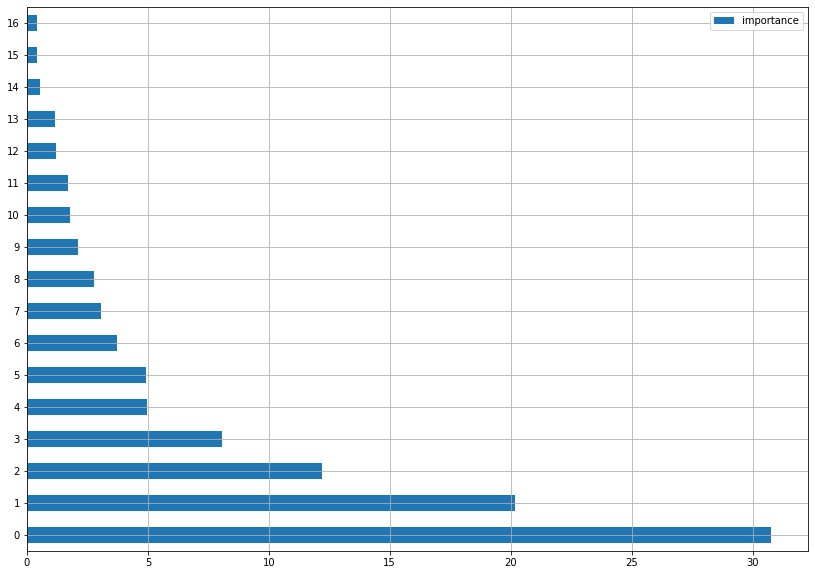

In [15]:
# model is the trained model
importances = model.feature_importances_

# train_features is the dataframe of training features
feature_list = list(features_upsampled.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

print(feature_results)

feature_results.plot(kind = 'barh', grid = True, figsize = (14, 10))

Получим предсказания и посчитаем метрику на валидационной выборке.

In [16]:
pred_valid = model.predict_proba(features_valid)
pred_valid_acc = model.predict(features_valid)
prob_one_valid = pred_valid[:, 1]
print('ROC-AUC валидационной выборки:', roc_auc_score(target_valid, prob_one_valid).round(3))
print('Accuracy валидационной выборки:', accuracy_score(target_valid, pred_valid_acc).round(3))

ROC-AUC валидационной выборки: 0.88
Accuracy валидационной выборки: 0.807


На валидационной выборке подбирались гиперпараметры модели и дорабатывались данные. По итогу проверяем полученную модель на тестовой выборке.

In [17]:
pred_test = model.predict_proba(features_test)
pred_test_acc = model.predict(features_test)
prob_one_test = pred_test[:, 1]
print('ROC-AUC тестовой выборки:', roc_auc_score(target_test, prob_one_test).round(3))
print('Accuracy тестовой выборки:', accuracy_score(target_test, pred_test_acc).round(3))

ROC-AUC тестовой выборки: 0.886
Accuracy тестовой выборки: 0.793


Довольно неплохой результат. Рассмотрим теперь модель `RandomForestClassifier`.

<a id = '2.2'></a>
### 2.2. RandomForestClassifier.

Отметим сразу что часть наиболее приемлимых параметров подбиралась с помощью GridSearch (код следующей ячейки) и они равны: n_estimators = 225, max_depth = 27. Код поиска закомментирован, чтобы не тратить время на очередной перебор.

In [18]:
#  forest_parametrs = {
#      'n_estimators' : range (5, 300, 5)
#      'max_depth' : range (1, 51, 2)
#  }

# forest_grid = GridSearchCV(rfc_model, forest_parametrs, scoring = 'roc_auc', cv = 5)
# forest_grid.fit(features_upsampled_enc, target_upsampled_enc)
# forest_grid.best_params_

In [19]:
%%time
rfc_model = RandomForestClassifier(random_state = 1, min_samples_split = 55,
                                   n_estimators = 225, max_depth = 27)
rfc_model.fit(features_upsampled_enc, target_upsampled_enc)

CPU times: user 2.88 s, sys: 0 ns, total: 2.88 s
Wall time: 2.91 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=27, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=55,
                       min_weight_fraction_leaf=0.0, n_estimators=225,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

             feature  importance
0           duration    0.295595
1       TotalCharges    0.163206
2               Type    0.139447
3     MonthlyCharges    0.138085
4    InternetService    0.060921
5      PaymentMethod    0.037373
6     OnlineSecurity    0.028772
7           internet    0.026481
8        TechSupport    0.020997
9   PaperlessBilling    0.017877
10   StreamingMovies    0.013112
11     MultipleLines    0.012576
12      OnlineBackup    0.011410
13       StreamingTV    0.010291
14        Dependents    0.009090
15  DeviceProtection    0.008302
16             phone    0.006464


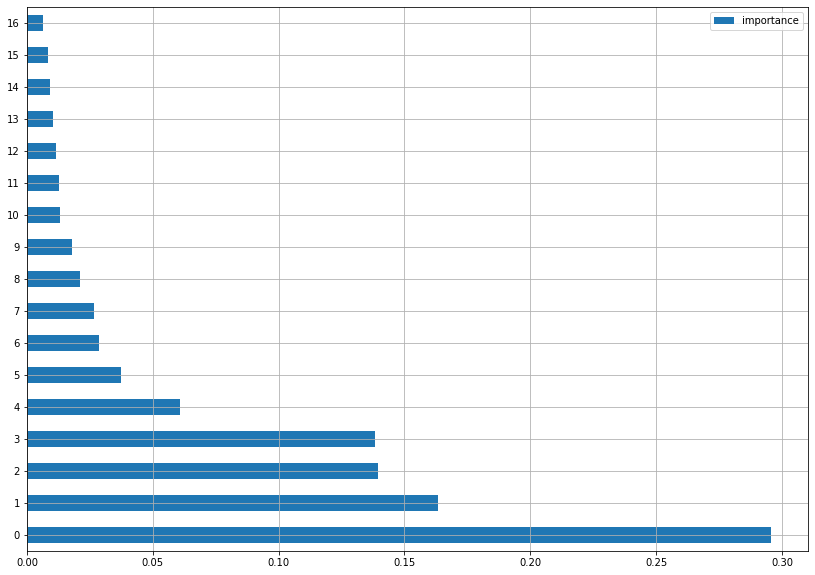

In [20]:
# model is the trained model
importances = rfc_model.feature_importances_

# train_features is the dataframe of training features
feature_list = list(features_upsampled_enc.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

print(feature_results)

feature_results.plot(kind = 'barh', grid = True, figsize = (14, 10))

In [21]:
rfc_predicted_valid = rfc_model.predict_proba(features_valid_enc)
rfc_predicted_valid_acc = rfc_model.predict(features_valid_enc)
probabilities_one_valid = rfc_predicted_valid[:, 1]
print('ROC-AUC валидационной выборки:', roc_auc_score(target_valid_enc, probabilities_one_valid).round(3))
print('Accuracy валидационной выборки:', accuracy_score(target_valid_enc, rfc_predicted_valid_acc).round(3))

ROC-AUC валидационной выборки: 0.867
Accuracy валидационной выборки: 0.819


На валидационной выборке подбирались гиперпараметры модели и дорабатывались данные. По итогу проверяем полученную модель на тестовой выборке.

In [22]:
rfc_predicted_test = rfc_model.predict_proba(features_test_enc)
rfc_predicted_test_acc = rfc_model.predict(features_test_enc)
probabilities_one_test = rfc_predicted_test[:, 1]
print('ROC-AUC тестовой выборки:', roc_auc_score(target_test_enc, probabilities_one_test).round(3))
print('Accuracy тестовой выборки:', accuracy_score(target_test_enc, rfc_predicted_test_acc).round(3))

ROC-AUC тестовой выборки: 0.877
Accuracy тестовой выборки: 0.814


Эта модель показала себя немного хуже, но тоже довольно неплохо.

Для наглядности построим ROC-кривые обеих моделей в сравнении с друг другом и случайной моделью.

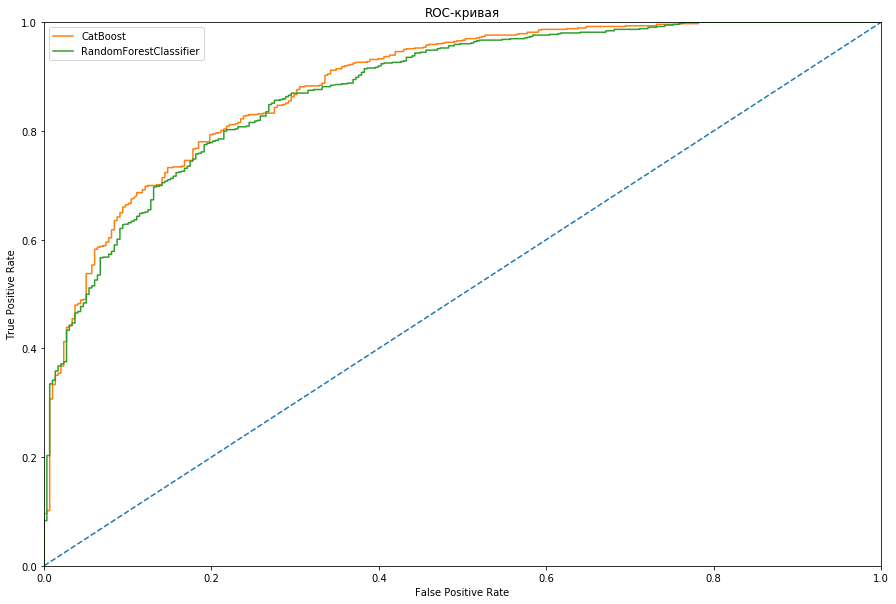

In [23]:
fpr, tpr, thresholds = roc_curve(target_test, prob_one_test)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(target_test_enc, probabilities_one_test)
plt.figure(figsize = (15, 10))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.plot(fpr, tpr, label = 'CatBoost')
plt.plot(fpr_rfc, tpr_rfc, label = 'RandomForestClassifier')
plt.legend()
plt.show()

___
[К содержанию](#back)

<a id = 'Conclusions'></a>
# <center>Выводы</center>

Нам предоставлены данные высокого качества: пропуски отсутствуют, работы с преобразованием типов не требовалось. Для каждого набора данных имеется признак `customerID` по которому были объединены представленные таблицы как для анализа данных, так и для последующей работы с моделью.   

Из исходных данных были сформированы допустимые для представления моделям `CatBoost` и `RandomForestClassifier`. По итогу работы с двумя моделями были получены довольно высокие показатели метрик, однако лучшей себя показала `CatBoost`, `AUC-ROC` которой на тестовой выборке равен 0,889.   
При этом стоит отметить что обучение `CatBoost` длилось дольше примерно в 14 раз, чем `RandomForestClassifier`, а разница метрик между этими моделями составляет 0,018, так что при необходимости имеет смысл выбрать - чем пожертвовать: скоростью обучения, либо небольшим ухудшением метрики.

In [24]:
print(full_data['MonthlyCharges'].corr(full_data['TotalCharges']))

0.6511738315787842


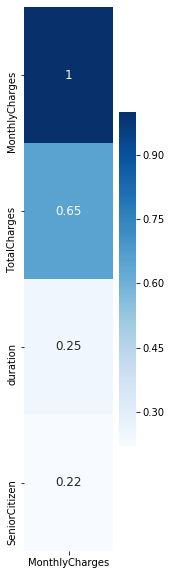

In [25]:
plt.figure(figsize=(2,10))
sns.heatmap(full_data.corr()[['MonthlyCharges']].sort_values(by='MonthlyCharges', ascending=False), cmap="Blues", 
            annot=True, annot_kws={'size':12})